# **Image Prompt**

In [1]:
prompts = [
    # "A cat sitting next to a bus.",
    # "A dog chasing a butterfly in a meadow.",
    # "A child holding a red balloon in a park.",
    # "A chef preparing sushi in a kitchen.",
    # "A bird perched on a windowsill with a view of the city skyline.",
    # "A woman reading a book under a large oak tree.",
    # "A dog sitting beside a zebra, both looking in different directions.",
    # "A robot serving coffee in a cozy café.",
    "A man playing the violin on a quiet beach at sunset.",
    # "A pair of glasses resting on a stack of books.",
    # "A horse grazing in a field with a mountain in the background.",
    # "A giraffe drinking water next to a small pond.",
    # "A boat floating on a calm lake with a forest in the distance.",
    # "A bicycle leaning against a lamppost in a quiet street.",
    # "A painter working on a canvas with a cityscape in the background.",
    # "A picnic setup with a basket, blanket, and fruit on a sunny day.",
    # "A skateboard leaning against a graffiti-covered wall.",
    # "A piano in a large, empty concert hall.",
    # "A lighthouse standing tall on a rocky cliff by the ocean.",
    # "A telescope pointing towards the night sky filled with stars.",
    # 'there are a robot made of gold and a robot made of silver are standing on an exotic planet with a red butterfly flying around them.',
    #  "A red car passing by a fire hydrant on the sidewalk.",
    #  "Apainting of a couple holding a yellow umbrella in a street on a rainy night. The woman is wearing a white dress and the man is wearing a blue suit.",
    # "An old time car is parked at the curb near a stop sign.",
    #  "A mirror, a white sink and a vase with red flowers in a bathroom with an artificial light.",
    #  "A cow standing next to a damaged car on a dirty lot.",
]

# Install dependencies for Stable / Dense Diffusion and Detectron2



In [2]:
import os
if not os.path.exists('/content/sam_vit_h_4b8939.pth'):

  # Dense Diffusion Libraries
  !pip -q uninstall -y jax jaxlib flax
  !pip -q install jax==0.4.19 jaxlib==0.4.19 flax==0.8.3
  !pip -q install diffusers==0.20.2 transformers==4.28.0 gradio==3.43.2 accelerate
  !pip -q install torch numpy tqdm Pillow torchvision

  # Our Libraries
  !pip -q install ultralytics
  !pip -q install 'git+https://github.com/facebookresearch/segment-anything.git'
  !pip -q install openai
  !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

# **Importing Libraries**

In [3]:
# General Libraries
import re
import torch
import matplotlib.pyplot as plt
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from openai import OpenAI
import ast
from google.colab import userdata
import json

# Stable Diffusion Libraries
from diffusers import StableDiffusionPipeline, DiffusionPipeline, DDIMScheduler

# Specific Dense Diffusion Libraries
import random
import pickle
from tqdm.auto import tqdm
import transformers
from transformers import CLIPTextModel, CLIPTokenizer
import torch.nn.functional as F
from torchvision import transforms
import diffusers

# YOLO & SAM Libraries
import ultralytics
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamPredictor
from IPython.display import display
from PIL import Image

# Check Ultralytics installation
ultralytics.checks()

Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.6/201.2 GB disk)


# **GPT 4o Mini**

In [4]:
def gpt_4o_mini(prompt, instruction):
    client = OpenAI(api_key=userdata.get("OPENAI_API_KEY"))
    messages = [
        {"role": "system", "content": instruction},
        {"role": "user", "content": prompt}
    ]
    try:
        completion = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=messages
        )
        response = completion.choices[0].message.content
    except Exception as e:
        print(f"An error occurred while calling GPT 4o mini: {e}")
        response = ""
    return response

# **Object Identifier**

In [5]:
def getobjects(user_input):
    instruction = "You are an object detection assistant, skilled in identifying simple and drawable objects from the prompt."
    prompt = f"""
    Extract simple and drawable objects from the prompt. Avoid backgrounds/setting/place. The prompt will have the following format, "Prompt: \"A cat sitting on a mat.\" Return the objects in a list like as follows "Cat", "Mat".
    Prompt: "{user_input}"
    """
    gpt_4o_mini_response = gpt_4o_mini(prompt, instruction)
    try:
        # Try to parse with ast.literal_eval
        identified_objects = ast.literal_eval(gpt_4o_mini_response)
    except (ValueError, SyntaxError):
        try:
            # Fallback to JSON parsing
            identified_objects = json.loads(gpt_4o_mini_response)
        except json.JSONDecodeError as e:
            try:
                identified_objects = gpt_4o_mini_response.split(", ")
            except Exception as e:
                print("gpt_4o_mini_response =", gpt_4o_mini_response)
                print(f"An error occurred while parsing the response: {e}")
                identified_objects = []
    return identified_objects

# **Prompt Generator**

In [6]:
def get_edited_prompts(user_input, identified_object):
    instruction = "You are an AI assistant that simplifies prompts by focusing on a specific object mentioned in the prompt to make it easier for stable diffusion to generate an image."
    prompt = f"""
    You are given a prompt and an object.
    The prompt describes a scene in which multiple objects are interacting with each other.
    The object you are provided with is one of the objects in the prompt.
    Your task is to create a simpler prompt that focuses more on the given object and less on the other objects in the original prompt.
    Make the simpler prompt short and to the point, so that it is easier for stable diffusion to generate an image with the given object in a simpler and easier layout.

    Return only the simplified prompt without any additional text.

    Original Prompt: "{user_input}"
    Object: "{identified_object}"
    """

    gpt_4o_mini_response = gpt_4o_mini(prompt, instruction)
    # Remove any extra quotation marks from the response
    edited_prompt = gpt_4o_mini_response.strip().strip('"')

    return edited_prompt


# **Making Object & Editied Prompts arraies**

In [7]:
# Arrays to store objects and edited prompts
objects_array = []
edited_prompts_array = []

recusive_diff_prompt = prompts[0]

# Step 1: Identify objects in the recusive_diff_prompt
identified_objects = getobjects(recusive_diff_prompt)

if isinstance(identified_objects, str):
  identified_objects = [identified_objects]

print("identified_objects =",identified_objects)

# Step 2: Generate edited recusive_diff_prompts for each identified object
for obj in identified_objects:
    # check
    if(obj.lower() not in recusive_diff_prompt.lower()):
      print(f"Object '{obj}' not found in the recusive_diff_prompt. Skipping...")
      continue

    edited_prompt = get_edited_prompts(recusive_diff_prompt, obj)

    # checking if obj in editied prompt
    if(obj.lower() not in edited_prompt.lower()):
      print(f"Object = '{obj}' not found in the edited prompt. edited_prompt = {edited_prompt} Skipping...")
      continue

    # Store in arrays
    objects_array.append(obj)
    edited_prompts_array.append(edited_prompt)

# Print arrays to verify
print("===================================")
print("Objects Array:", objects_array)
print("Edited Prompts Array:", edited_prompts_array)

identified_objects = ['Man', 'Violin']
Objects Array: ['Man', 'Violin']
Edited Prompts Array: ['A man playing the violin on a beach at sunset.', 'A violin on a quiet beach at sunset.']


# **Load New Stable Diffusion Model**

In [8]:
# Ensure to reset any previous model
import shutil

# Define the cache directory
cache_dir = './models/diffusers/'

# Remove the cache directory
shutil.rmtree(cache_dir, ignore_errors=True)

pipe = None # Reset
torch.cuda.empty_cache()  # Clear GPU cache if using CUDA

device = "cuda:0"
# Example entities
# entities = edited_prompts_array

# Load the Stable Diffusion 1.5 model with specified scheduler and configuration
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    safety_checker=None,
    variant="fp16",
    cache_dir=cache_dir,
    force_download=True,  # Force re-download the model
    use_auth_token=userdata.get("HF_TOKEN")
).to(device)

pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.scheduler.set_timesteps(50)
timesteps = pipe.scheduler.timesteps
sp_sz = pipe.unet.sample_size
bsz = 1

print("Pipe Setup complete. Token and device initialized.")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Pipe Setup complete. Token and device initialized.


# **Image Generation for Mask using Editied Prompts**

In [9]:
# Function to generate image from prompt using the loaded pipeline
def generate_image(prompt):
    image = pipe(prompt).images[0]
    return image

images = []

# Making Image for simple Stable Diffusion
print("Generating simple stable diffusion image")
stable_diffusion_image = generate_image(recusive_diff_prompt)

for idx, entity in enumerate(edited_prompts_array):
    print(f"Processing entity {idx + 1}/{len(edited_prompts_array)}: {entity}")
    image = generate_image(entity)
    images.append(image)

Generating simple stable diffusion image


  0%|          | 0/50 [00:00<?, ?it/s]

Processing entity 1/2: A man playing the violin on a beach at sunset.


  0%|          | 0/50 [00:00<?, ?it/s]

Processing entity 2/2: A violin on a quiet beach at sunset.


  0%|          | 0/50 [00:00<?, ?it/s]

# **Loading YOLO & SAM**

In [10]:
# Load YOLOv8 model
model = YOLO('/content/yolov8n.pt')

# Load SAM model
sam_checkpoint = "/content/sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to("cuda")
predictor = SamPredictor(sam)

# **Helper Functions for Extracting Object Segments**

In [11]:
def random_color(used_colors):
    while True:
        color = tuple(np.random.randint(0, 255, size=3, dtype=np.uint8))
        if color not in used_colors:
            used_colors.add(color)
            return color

def get_relevant_object(target_object, detected_objects, original_prompt):
    instruction = "You are an AI assistant that helps identify the most relevant object from a list of detected objects based on a target object and the original prompt. This relevant object will be used by YOLO and SAM for segmentation purposes. Consider common associations, relationships, similar shapes, sizes, tasks, and appearances of objects."

    prompt = f"""
    Target Object: {target_object}
    Detected Objects: {detected_objects}
    Original Prompt: {original_prompt}

    Think about how objects are commonly related or associated. Consider relationships, similar-looking objects, objects with similar shapes or sizes, and objects that perform similar tasks.

    Here are some examples to guide you:
    1. If the target object is 'pencil' and the detected objects include 'pen', the relevant object might be 'pen' because they perform similar tasks.
    2. If the target object is 'car' and the detected objects include 'truck', the relevant object might be 'truck' because they are similar in shape and function.
    3. If the target object is 'dog' and the detected objects include 'cat', the relevant object might be 'cat' because they are both animals and similar in size.
    4. If the target object is 'salesman' and the detected objects include 'person', the relevant object might be 'person' because a salesman is a type of person.
    5. If the target object is 'toy' and the detected objects include 'robot', the relevant object might be 'robot' because toys and robots can be similar in shape.

    Your task is to determine which detected object is most relevant to the target object based on these factors. Return only the most relevant object from the list of detected objects without any explanation.
    """

    response = gpt_4o_mini(prompt, instruction)
    return response

# **Extracting Object Segments**

In [12]:
used_colors = set()

# Define segmentation function
def segment_image(image, target_object, edited_prompt,recusive_diff_prompt):
    # Perform object detection using YOLOv8
    results = model.predict(source=image, conf=0.4, device="cuda")

    annotated_frame = results[0].plot()

    # Extract bounding boxes and class names
    detected_objects = []
    bboxes = []
    for result in results:
        boxes = result.boxes
        class_ids = result.boxes.cls
        detected_objects.extend([model.names[int(cls)] for cls in class_ids])
        bboxes.extend(boxes.xyxy.tolist())

    # Print the names of detected objects
    print("Detected Objects:", detected_objects)

    # Ensure the input image is in numpy array format
    if isinstance(image, Image.Image):
        image = np.array(image)
    elif isinstance(image, str):
        image = cv2.imread(image)

    if image is None:
        raise ValueError("The image could not be loaded. Please check the image path or object.")

    # Convert image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if len(detected_objects) == 0:
        print("No objects detected in the image.")
        display_images(image_rgb, annotated_frame, None, title=edited_prompt, status="No Objects in image", target_class_name=target_object)
        return None

    # Get the relevant object
    target_object = target_object.lower()
    relevant_object = get_relevant_object(target_object, detected_objects, recusive_diff_prompt)
    print("relevant_object =",relevant_object)

    if relevant_object.lower() not in detected_objects:
        print(f"Object '{target_object}' not found in the image.")
        display_images(image_rgb, annotated_frame, None, title=edited_prompt, status="Object not found", target_class_name=target_object)
        return None

    # Updating target_object to relevant_object
    target_object = relevant_object

    predictor.set_image(image_rgb)

    masks_dict = {}

    # Perform segmentation for the target object
    for bbox, obj_name in zip(bboxes, detected_objects):
        if obj_name == target_object:
            input_box = np.array(bbox)

            masks, _, _ = predictor.predict(
                point_coords=None,
                point_labels=None,
                box=input_box[None, :],
                multimask_output=False,
            )

            # Store the binary mask in the dictionary
            segmentation_mask = masks[0]

            extracted_image = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)

            # Apply the mask to the original image with a unique color
            color = random_color(used_colors)
            extracted_image[segmentation_mask] = [color[2], color[1], color[0], 255]

            # Convert to RGBA format
            extracted_image = cv2.cvtColor(extracted_image, cv2.COLOR_BGRA2RGBA)

            extracted_pil_image = Image.fromarray(extracted_image)

            # Convert the original image to RGBA for compositing
            image_rgba = Image.fromarray(image_rgb).convert('RGBA')

    display_images(image_rgb, annotated_frame, extracted_image, title=edited_prompt, status="Segmentation complete", target_class_name=target_object)
    return extracted_pil_image

def display_images(original_image, out_image, extracted_image=None, title="", status="", target_class_name=""):

    # Ensure original_image is in the correct format
    if isinstance(original_image, Image.Image):
        original_image = np.array(original_image)
    elif isinstance(original_image, str):
        original_image = cv2.imread(original_image)

    if original_image is None:
        raise ValueError("The original image could not be loaded. Please check the image path or object.")

    # Convert images to RGB for display
    original_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    out_rgb = cv2.cvtColor(out_image, cv2.COLOR_BGR2RGB)

    if extracted_image is not None:
        extracted_rgb = cv2.cvtColor(np.array(extracted_image), cv2.COLOR_RGBA2RGB)
        combined_image = np.hstack((original_rgb, out_rgb, extracted_rgb))
    else:
        combined_image = np.hstack((original_rgb, out_rgb))

    # Use matplotlib to display the combined image with title
    plt.figure(figsize=(15, 5))
    plt.imshow(combined_image)
    plt.axis('off')
    display_text = f"Object: {target_class_name} || Prompt: {title} || Status: {status}"
    plt.title(display_text)
    plt.show()


# **Changing Object Names to work with SAM**

In [13]:
extracted_images = {}
target_object_array = [items.lower() for items in objects_array]
print("target_object_array =",target_object_array)

target_object_array = ['man', 'violin']


# **Extracting Mask Segments**

target_object = man

0: 640x640 1 person, 11.0ms
Speed: 47.2ms preprocess, 11.0ms inference, 136.7ms postprocess per image at shape (1, 3, 640, 640)
Detected Objects: ['person']
relevant_object = person


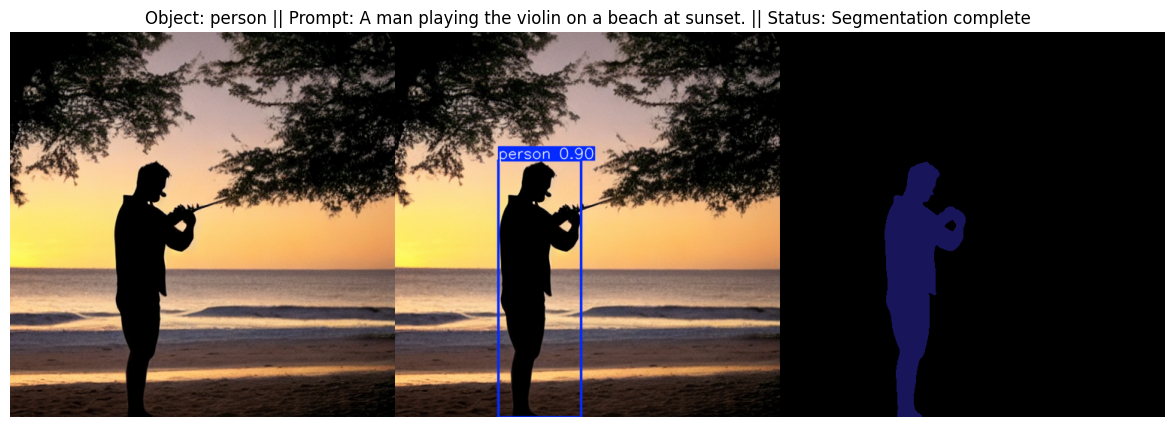

target_object = violin

0: 640x640 (no detections), 13.9ms
Speed: 3.7ms preprocess, 13.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Detected Objects: []
No objects detected in the image.


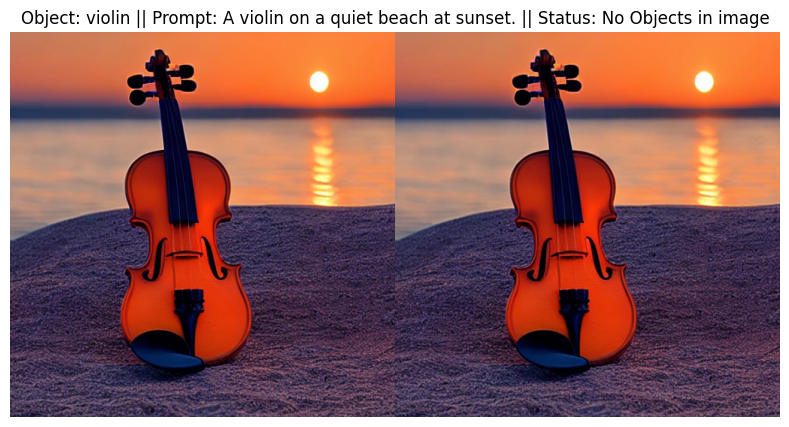

In [14]:
# Iterate through images and entity array
for i, (image, target_object) in enumerate(zip(images, target_object_array)):
    edited_prompt = edited_prompts_array[i]
    # entity = entities[i]
    print("target_object =", target_object)
    mask = segment_image(image, target_object,edited_prompt,recusive_diff_prompt)
    extracted_images[target_object] = mask
# print("extracted_images =",extracted_images)

# **Matching Object array with Segmentation Target Class**

In [15]:
print("old extracted_images =",extracted_images)
print("objects_array =",objects_array)
size = len(objects_array)

extracted_images_copy = {}
objects_array_copy = objects_array.copy()
objects_array=[]

for index in range(size):
  print("index =",index)
  objects_array_copy.reverse()
  curr_obj = objects_array_copy.pop()
  objects_array_copy.reverse()
  curr_obj = curr_obj.lower()
  print("curr_obj =",curr_obj)
  if(extracted_images[curr_obj] != None):
    extracted_images_copy[curr_obj] = extracted_images[curr_obj]
    objects_array.append(curr_obj)

extracted_images = extracted_images_copy

print("new extracted_images")
print(extracted_images)
print("objects_array =",objects_array)

old extracted_images = {'man': <PIL.Image.Image image mode=RGBA size=512x512 at 0x7B95807AF220>, 'violin': None}
objects_array = ['Man', 'Violin']
index = 0
curr_obj = man
index = 1
curr_obj = violin
new extracted_images
{'man': <PIL.Image.Image image mode=RGBA size=512x512 at 0x7B95807AF220>}
objects_array = ['man']


#**Getting Stacking order for extracted segments from GPT 4o mini**

In [16]:
def get_grid_positions_and_stack(prompt, objects_array):
    instruction = """
    You are an AI assistant that arranges objects in a 3x3 grid based on a prompt and a list of extracted objects.
    """

    prompt_content = f"""
    1 2 3
    4 5 6
    7 8 9
    You are provided with a prompt and a list of extracted objects. For each object, determine which box(es) it should occupy in the grid. If the object occupies multiple boxes, list all the boxes it occupies. Additionally, determine the stacking order of the objects, meaning which objects should appear on top of others.

    Consider the objects' relationship in the prompt and suggest the most visually appealing and logically correct arrangement.

    This arrangement is intended for creating masks to be used in a Dense Diffusion model.

    Return the result in a valid JSON format as follows:
    {{
        "grid_positions": {{
            "Object Name 1": [list_of_boxes],
            "Object Name 2": [list_of_boxes]
        }},
        "stacking_order": ["Object Name 1", "Object Name 2"]
    }}
    Make sure the JSON is correctly formatted.

    Prompt: {prompt}
    Objects: {objects_array}
    """

    gpt_4o_mini_response = gpt_4o_mini(prompt_content, instruction)

    # Remove triple backticks and any extra whitespace
    cleaned_response = gpt_4o_mini_response.strip("```").strip()

    # Check for prefix issues like "json\n{...}"
    if cleaned_response.startswith("json"):
        cleaned_response = cleaned_response[len("json"):].strip()

    # Remove any comments in the response
    cleaned_response = '\n'.join(line for line in cleaned_response.splitlines() if not line.strip().startswith("//"))

    # print("cleaned_response =", cleaned_response)

    try:
        gpt_4o_mini_response = json.loads(cleaned_response)
        grid_positions_by_gpt = gpt_4o_mini_response["grid_positions"]
        stacking_order_by_gpt = gpt_4o_mini_response["stacking_order"]

        print("gpt_4o_mini_response =", gpt_4o_mini_response)
    except json.JSONDecodeError as e:
        print("Error decoding JSON:", str(e))
        grid_positions_by_gpt = None
        stacking_order_by_gpt = None

    return grid_positions_by_gpt, stacking_order_by_gpt

grid_positions,stacking_order = get_grid_positions_and_stack(recusive_diff_prompt, objects_array)
print("Grid Positions =",grid_positions)
print("Stacking Order =",stacking_order)

gpt_4o_mini_response = {'grid_positions': {'man': [5]}, 'stacking_order': ['man']}
Grid Positions = {'man': [5]}
Stacking Order = ['man']


# **Making numeric Stacking order for Composite Mask**

In [17]:
#Specify the order
# stacking_order
default_order_of_images = list(extracted_images.keys())
print("default_order_of_images =",default_order_of_images)
print("stacking_order =",stacking_order)
order = []
for image in stacking_order:
  i = 1
  for curr_image in objects_array:
    if(image.lower() == curr_image.lower()):
      order.append(i)
      break
    i += 1

print("extracted_images =",extracted_images)

# order
# Segmentation stacking order = Top .... Bottom
print("order =",order)

default_order_of_images = ['man']
stacking_order = ['man']
extracted_images = {'man': <PIL.Image.Image image mode=RGBA size=512x512 at 0x7B95807AF220>}
order = [1]


#**Making Composite Mask using stack order**

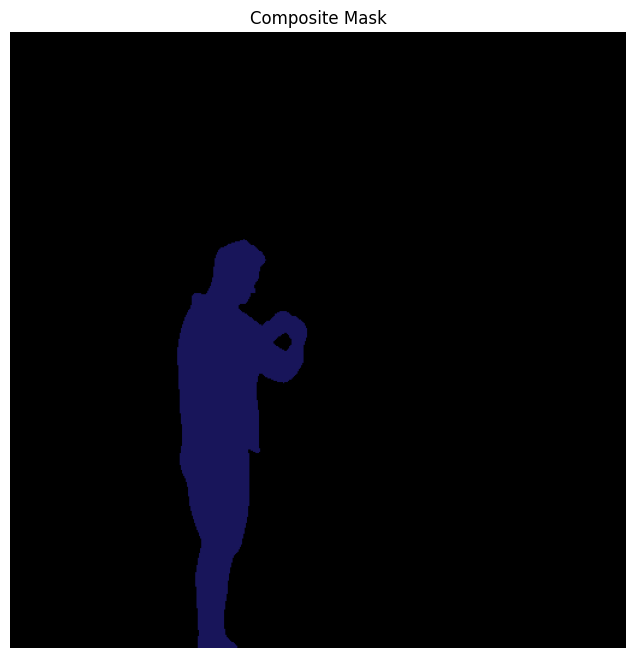

In [18]:
def overlay_images(images_dict, order):
    # Get the size of the images
    image_shape = next(iter(images_dict.values())).size  # Assuming all images are of the same size
    width, height = image_shape

    # Create a blank canvas with a black background
    canvas = Image.new('RGBA', (width, height), (0, 0, 0, 255))

    # Overlay images in the specified order
    for index in reversed(order):  # Reverse the order for correct overlay
        entity = list(images_dict.keys())[index - 1]
        img = images_dict[entity].convert('RGBA')
        canvas = Image.alpha_composite(canvas, img)

    return canvas

# Create the composite image
composite_image = overlay_images(extracted_images, order)

# Convert to RGB format for display with Matplotlib
composite_image_rgb = composite_image.convert('RGB')

# Display the composite image
plt.figure(figsize=(10, 8))
plt.imshow(composite_image_rgb)
plt.axis('off')
plt.title('Composite Mask')
plt.show()

# **Dense Diffusion**

# **Modified** Forward Function for **Attention Mechanism** with Regularization

In [19]:
def mod_forward(self, hidden_states, encoder_hidden_states=None, attention_mask=None, temb=None):

    residual = hidden_states

    if self.spatial_norm is not None:
        hidden_states = self.spatial_norm(hidden_states, temb)

    input_ndim = hidden_states.ndim

    if input_ndim == 4:
        batch_size, channel, height, width = hidden_states.shape
        hidden_states = hidden_states.view(batch_size, channel, height * width).transpose(1, 2)

    batch_size, sequence_length, _ = (hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape)
    attention_mask = self.prepare_attention_mask(attention_mask, sequence_length, batch_size)

    if self.group_norm is not None:
        hidden_states = self.group_norm(hidden_states.transpose(1, 2)).transpose(1, 2)

    query = self.to_q(hidden_states)

    sa_ = True if encoder_hidden_states is None else False
    encoder_hidden_states = text_cond if encoder_hidden_states is not None else hidden_states
    if self.norm_cross:
        encoder_hidden_states = self.norm_encoder_hidden_states(encoder_hidden_states)

    key = self.to_k(encoder_hidden_states)
    value = self.to_v(encoder_hidden_states)

    query = self.head_to_batch_dim(query)
    key = self.head_to_batch_dim(key)
    value = self.head_to_batch_dim(value)

    #################################################
    global COUNT

    if COUNT/32 < 50*reg_part:

        dtype = query.dtype
        if self.upcast_attention:
            query = query.float()
            key = key.float()

        sim = torch.baddbmm(torch.empty(query.shape[0], query.shape[1], key.shape[1],
                                        dtype=query.dtype, device=query.device),
                            query, key.transpose(-1, -2), beta=0, alpha=self.scale)

        treg = torch.pow(timesteps[COUNT//32]/1000, 5)

        ## reg at self-attn
        if sa_:
            min_value = sim[int(sim.size(0)/2):].min(-1)[0].unsqueeze(-1)
            max_value = sim[int(sim.size(0)/2):].max(-1)[0].unsqueeze(-1)
            mask = sreg_maps[sim.size(1)].repeat(self.heads,1,1)
            size_reg = reg_sizes[sim.size(1)].repeat(self.heads,1,1)

            sim[int(sim.size(0)/2):] += (mask>0)*size_reg*sreg*treg*(max_value-sim[int(sim.size(0)/2):])
            sim[int(sim.size(0)/2):] -= ~(mask>0)*size_reg*sreg*treg*(sim[int(sim.size(0)/2):]-min_value)


        ## reg at cross-attn
        else:
            min_value = sim[int(sim.size(0)/2):].min(-1)[0].unsqueeze(-1)
            max_value = sim[int(sim.size(0)/2):].max(-1)[0].unsqueeze(-1)
            mask = creg_maps[sim.size(1)].repeat(self.heads,1,1)
            size_reg = reg_sizes[sim.size(1)].repeat(self.heads,1,1)

            sim[int(sim.size(0)/2):] += (mask>0)*size_reg*creg*treg*(max_value-sim[int(sim.size(0)/2):])
            sim[int(sim.size(0)/2):] -= ~(mask>0)*size_reg*creg*treg*(sim[int(sim.size(0)/2):]-min_value)

        attention_probs = sim.softmax(dim=-1)
        attention_probs = attention_probs.to(dtype)

    else:
        attention_probs = self.get_attention_scores(query, key, attention_mask)

    COUNT += 1
    #################################################

    hidden_states = torch.bmm(attention_probs, value)
    hidden_states = self.batch_to_head_dim(hidden_states)

    # linear proj
    hidden_states = self.to_out[0](hidden_states)
    # dropout
    hidden_states = self.to_out[1](hidden_states)

    if input_ndim == 4:
        hidden_states = hidden_states.transpose(-1, -2).reshape(batch_size, channel, height, width)

    if self.residual_connection:
        hidden_states = hidden_states + residual

    hidden_states = hidden_states / self.rescale_output_factor

    return hidden_states

# **Override UNet Attention Mechanism** with Custom Forward Function

In [20]:
for _module in pipe.unet.modules():
    if _module.__class__.__name__ == "Attention":
        _module.__class__.__call__ = mod_forward

# **Generating Prompts and Layout Image**

In [21]:
dense_diffusion_prompt = []
dense_diffusion_prompt.append(recusive_diff_prompt)
dense_diffusion_prompt.append("")

# Check original dense diffusion code to see in which order are the objects added!
for obj in stacking_order:
  dense_diffusion_prompt.append(obj.lower())

print("dense_diffusion_prompt =",dense_diffusion_prompt)

dense_diffusion_prompt = ['A man playing the violin on a quiet beach at sunset.', '', 'man']


# **Tokenizing Prompts, Processing Layout Image**


A man playing the violin on a quiet beach at sunset.

man


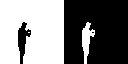

In [22]:
# Tokenize the dense_diffusion_prompt
text_input = pipe.tokenizer(dense_diffusion_prompt, padding="max_length", return_length=True, return_overflowing_tokens=False,
                            max_length=pipe.tokenizer.model_max_length, truncation=True, return_tensors="pt")
cond_embeddings = pipe.text_encoder(text_input.input_ids.to(device))[0]

uncond_input = pipe.tokenizer([""] * bsz, padding="max_length", max_length=pipe.tokenizer.model_max_length,
                              truncation=True, return_tensors="pt")
uncond_embeddings = pipe.text_encoder(uncond_input.input_ids.to(device))[0]

# Ensure that wlen matches the length of widx
for i in range(1, len(dense_diffusion_prompt)):
    wlen = text_input['length'][i].item() - 2  # Convert tensor to int
    widx = text_input['input_ids'][i][1:1 + wlen]
    for j in range(77):
        if j + wlen <= 77 and (text_input['input_ids'][0][j:j + wlen] == widx).sum().item() == wlen:  # Use .item() to get the value
            break

# Process the layout image
layout_img_ = np.asarray(composite_image_rgb.resize([sp_sz * 8, sp_sz * 8]))[:, :, :3]
unique, counts = np.unique(np.reshape(layout_img_, (-1, 3)), axis=0, return_counts=True)
sorted_idx = np.argsort(-counts)

layouts_ = []

for i in range(len(dense_diffusion_prompt) - 1):
    if (unique[sorted_idx[i]] == [0, 0, 0]).all() or (unique[sorted_idx[i]] == [255, 255, 255]).all():
        layouts_ = [((layout_img_ == unique[sorted_idx[i]]).sum(-1) == 3).astype(np.uint8)] + layouts_
    else:
        layouts_.append(((layout_img_ == unique[sorted_idx[i]]).sum(-1) == 3).astype(np.uint8))

layouts = [torch.FloatTensor(l).unsqueeze(0).unsqueeze(0).cuda() for l in layouts_]
layouts = F.interpolate(torch.cat(layouts), (sp_sz, sp_sz), mode='nearest')

print('\n'.join(dense_diffusion_prompt))
Image.fromarray(np.concatenate([255 * _.squeeze().cpu().numpy() for _ in layouts], 1).astype(np.uint8))

# **Preparation for Spatial Regularization (sreg) and Cross-Attention Regularization (creg)**

In [23]:
###########################
###### prep for sreg ######
###########################
sreg_maps = {}
reg_sizes = {}
for r in range(4):
    res = int(sp_sz/np.power(2,r))
    layouts_s = F.interpolate(layouts,(res, res),mode='nearest')
    layouts_s = (layouts_s.view(layouts_s.size(0),1,-1)*layouts_s.view(layouts_s.size(0),-1,1)).sum(0).unsqueeze(0).repeat(bsz,1,1)
    reg_sizes[np.power(res, 2)] = 1-1.*layouts_s.sum(-1, keepdim=True)/(np.power(res, 2))
    sreg_maps[np.power(res, 2)] = layouts_s


###########################
###### prep for creg ######
###########################
pww_maps = torch.zeros(1, 77, sp_sz, sp_sz).to(device)
for i in range(1,len(dense_diffusion_prompt)):
    wlen = text_input['length'][i] - 2
    widx = text_input['input_ids'][i][1:1+wlen]
    for j in range(77):
        if j + wlen <= 77 and (text_input['input_ids'][0][j:j + wlen].shape == widx.shape and (text_input['input_ids'][0][j:j + wlen] == widx).sum().item() == wlen):
            pww_maps[:,j:j+wlen,:,:] = layouts[i-1:i]
            cond_embeddings[0][j:j+wlen] = cond_embeddings[i][1:1+wlen]
            print(dense_diffusion_prompt[i], i, '-th segment is handled.')
            break

creg_maps = {}
for r in range(4):
    res = int(sp_sz/np.power(2,r))
    layout_c = F.interpolate(pww_maps,(res,res),mode='nearest').view(1,77,-1).permute(0,2,1).repeat(bsz,1,1)
    creg_maps[np.power(res, 2)] = layout_c


###########################
#### prep for text_emb ####
###########################
text_cond = torch.cat([uncond_embeddings, cond_embeddings[:1].repeat(bsz,1,1)])

 1 -th segment is handled.
man 2 -th segment is handled.


# **Latent Generation and Image Synthesis**

In [24]:
reg_part = .3
sreg = .3
creg = 1.

COUNT = 0

with torch.no_grad():
    latents = torch.randn(bsz,4,sp_sz,sp_sz, generator=torch.Generator().manual_seed(1)).to(device)
    image = pipe(dense_diffusion_prompt[:1]*bsz, latents=latents).images

  0%|          | 0/50 [00:00<?, ?it/s]

# **Recursive Diffusion using Dense Diffusion Image**

recursive_diff_prompt = A man playing the violin on a quiet beach at sunset.


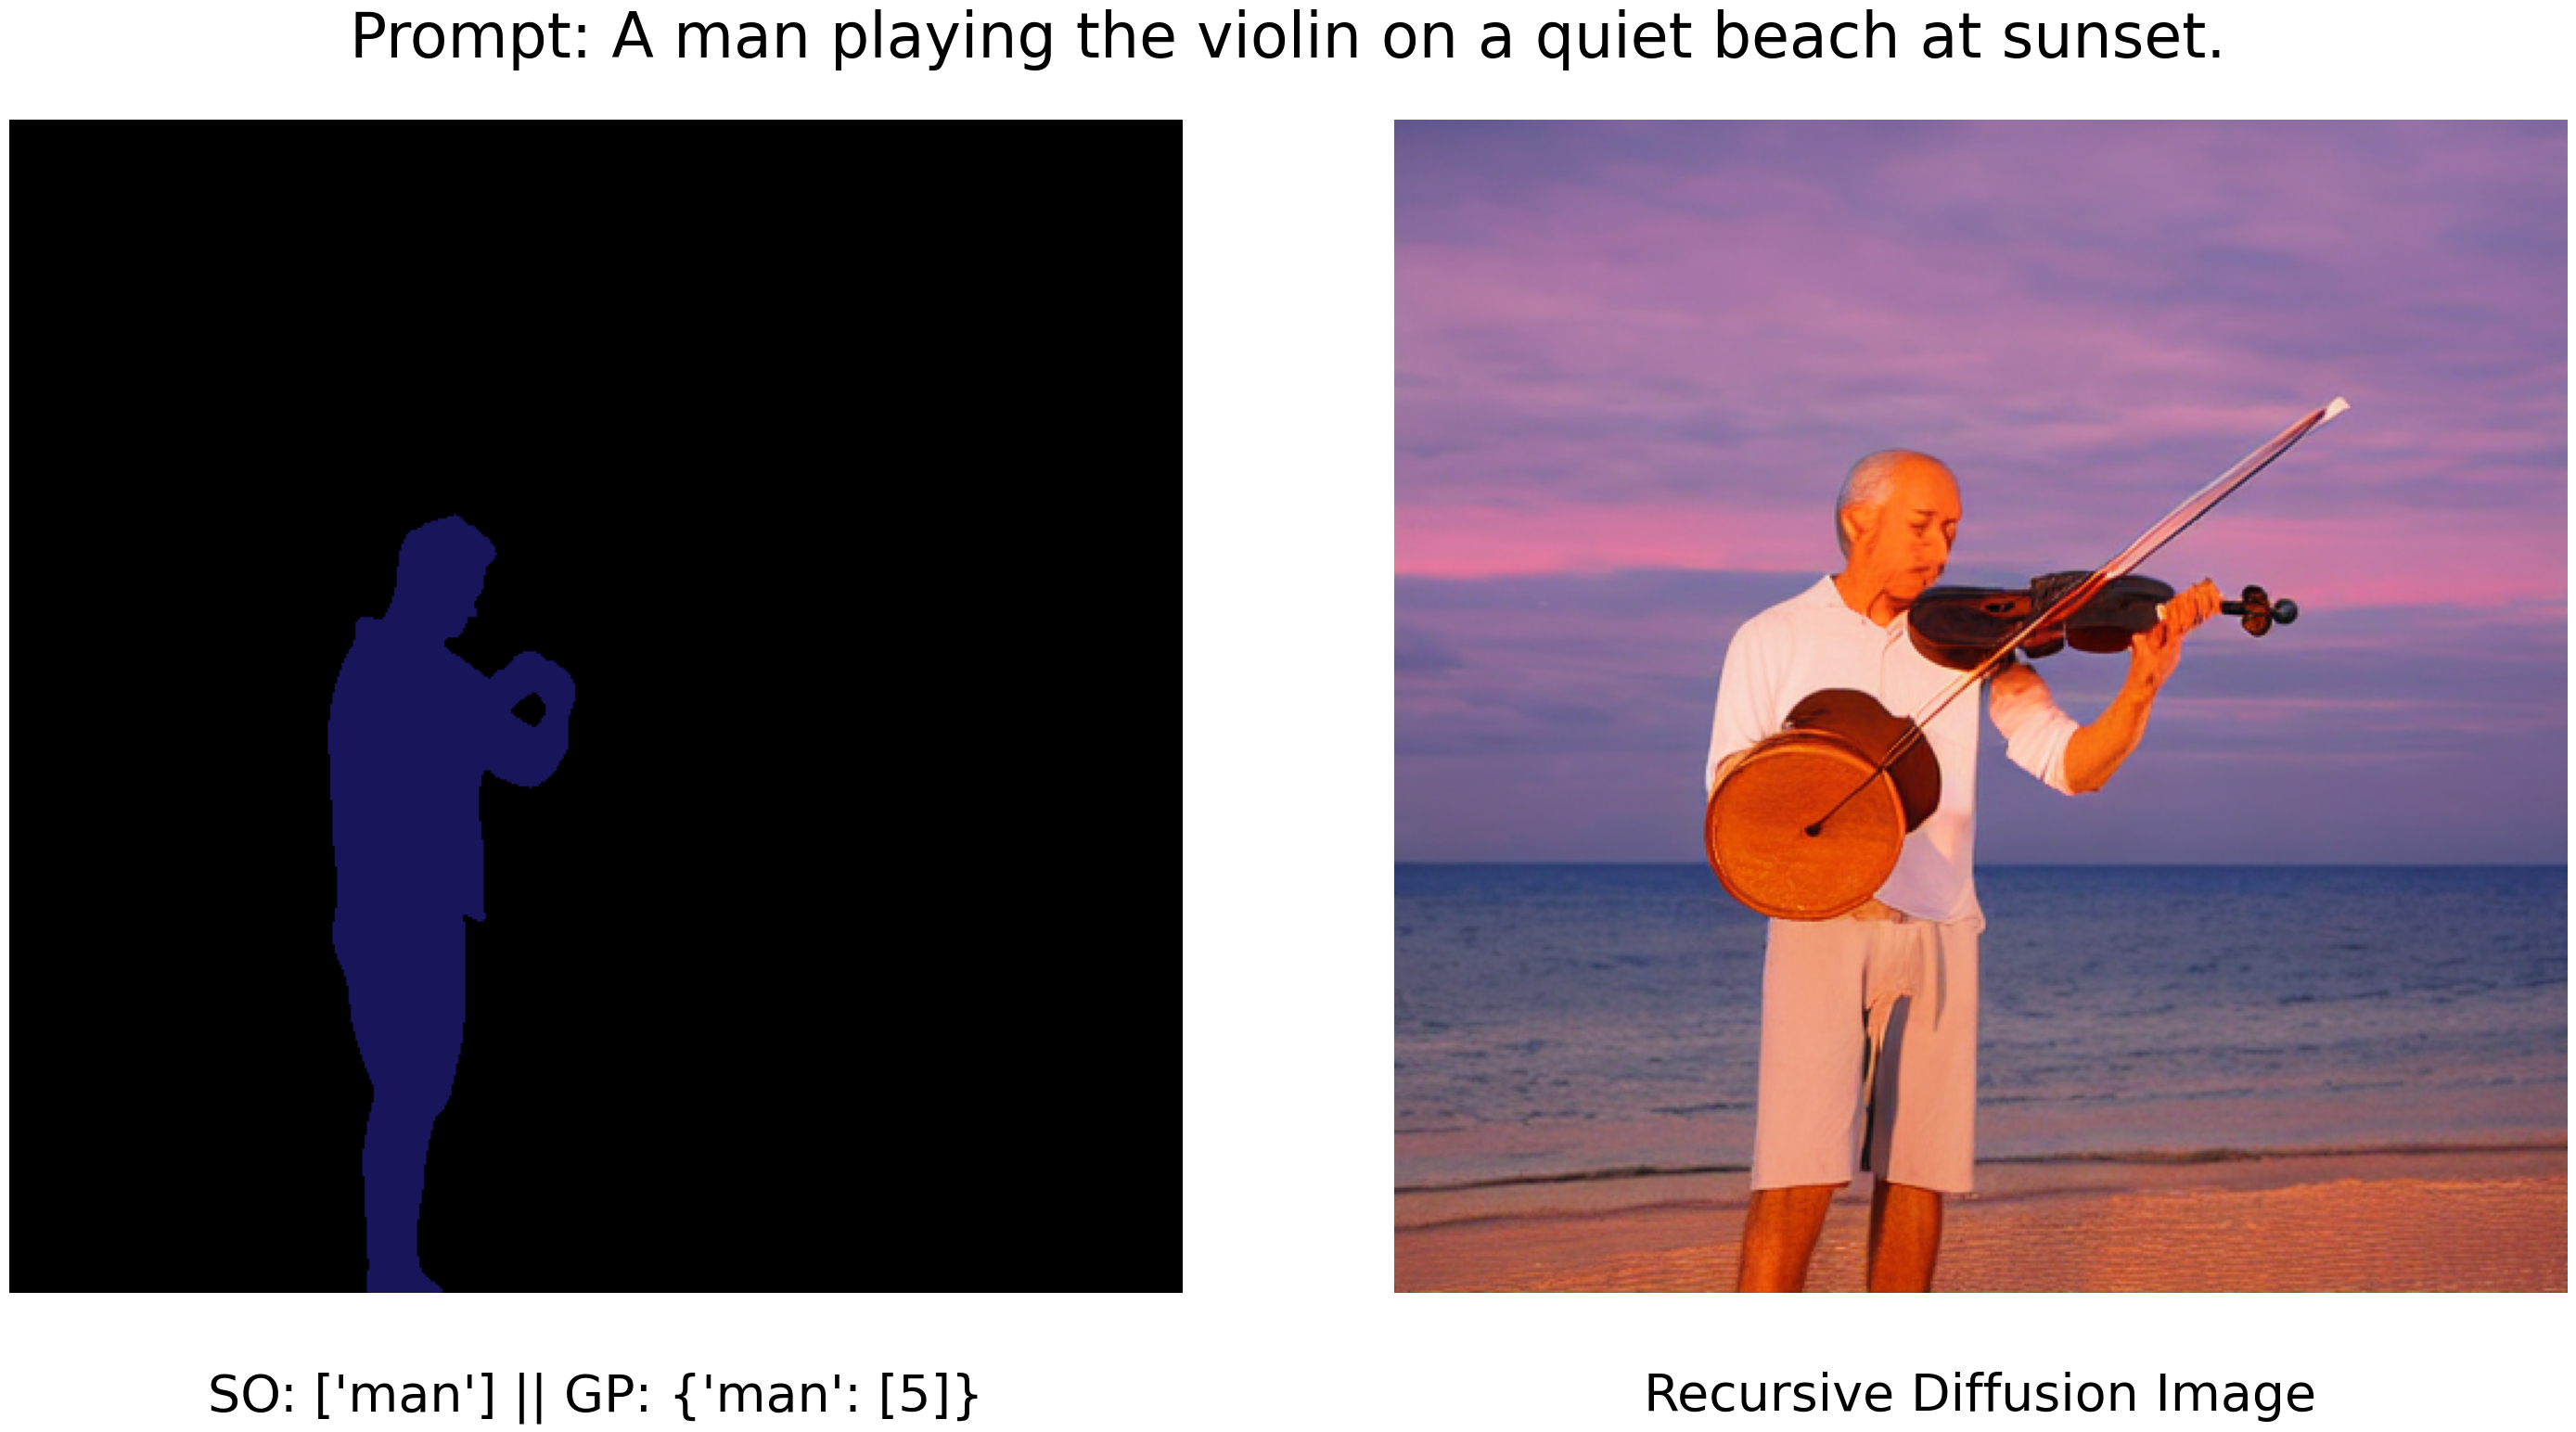

In [25]:
print("recursive_diff_prompt =", recusive_diff_prompt)

# Adjust the figsize for larger images
fig, axes = plt.subplots(1, len(image) + 1, figsize=(30, 15))

# Display the layout image with the stacking order title below the image
axes[0].imshow(layout_img_)
axes[0].axis('off')
axes[0].text(0.5, -0.1, f"SO: {str(stacking_order)} || GP: {grid_positions}", fontsize=40, ha='center', transform=axes[0].transAxes)

# Display each image with the corresponding title below the images
for i in range(len(image)):
    axes[i + 1].imshow(image[i])
    axes[i + 1].axis('off')
    axes[i + 1].text(0.5, -0.1, f"Recursive Diffusion Image", fontsize=40, ha='center', transform=axes[i + 1].transAxes)

# Set the combined title for the figure
fig.suptitle(f"Prompt: {recusive_diff_prompt}", fontsize=48)

# Adjust layout and display the plot
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust top to accommodate the suptitle
plt.show()

# **Simple Stable Diffusion Image**

Prompt = A man playing the violin on a quiet beach at sunset.


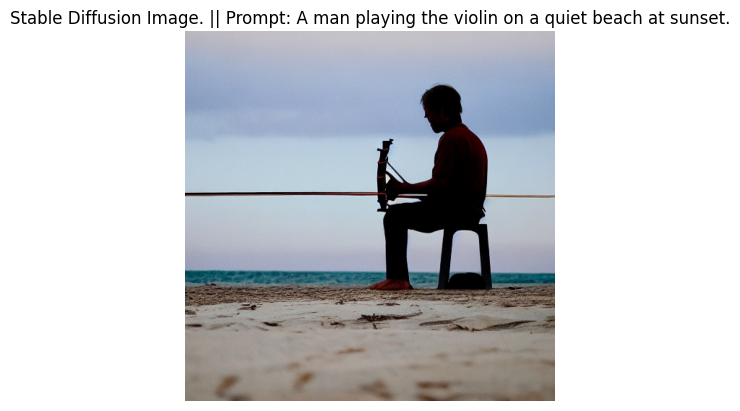

In [26]:
print("Prompt =",recusive_diff_prompt)
plt.imshow(stable_diffusion_image)
plt.axis('off')
display_text = 'Stable Diffusion Image. || Prompt: ' + recusive_diff_prompt
plt.title(display_text)
plt.show()